<a href="https://colab.research.google.com/github/aaalexlit/omdena_climate_change_challenge_notebooks/blob/main/Index_scientific_papers_abstracts_for_searches_with_sem_scholar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Index scientific papers abstracts for searches

## Download csv with the abstracts retrieved from OpenAlex using keyword search and then enriched with information from Semantic Scholar

This is a full version that has 1076115 abstracts

The csv was obtained using [this code](https://github.com/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/A_obtaining_data.ipynb) with some minor modifications from https://openalex.org/ 

In [ ]:
## we need this to be able to download big-ish files from GDrive
# %%capture
# !pip3 install --upgrade gdown

In [ ]:
!gdown https://drive.google.com/uc?id=1jc-fR--Csz6bxf1O6lBpgAtf38VLHTW9 -O 'mod_abstracts_title_keyword_search.csv'
!gdown https://drive.google.com/uc?id=1l5_zGXV5p9jESnqb1bQFGTRTfgFrthFp -O 'mod_abstracts_abstract_keyword_search.csv'

Downloading...
From: https://drive.google.com/uc?id=1jc-fR--Csz6bxf1O6lBpgAtf38VLHTW9
To: /content/mod_abstracts_title_keyword_search.csv
100% 10.4M/10.4M [00:00<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1l5_zGXV5p9jESnqb1bQFGTRTfgFrthFp
To: /content/mod_abstracts_abstract_keyword_search.csv
100% 928M/928M [00:08<00:00, 103MB/s] 


# Check if GPU is available to install gpu version of faiss

In [ ]:
import torch
import os
faiss_to_install = "faiss-gpu"
if not torch.cuda.is_available():
  faiss_to_install = "faiss"

ret_code = os.system(f"pip install farm-haystack[{faiss_to_install}]")
if not ret_code:
  print(f"Installed {faiss_to_install}")

Installed faiss-gpu


# Index documents 

In [ ]:
import os
from haystack.document_stores import FAISSDocumentStore
from haystack.nodes import EmbeddingRetriever
import logging
from timeit import default_timer as timer
from haystack import Document
import pandas as pd
import torch
from transformers import AutoTokenizer, pipeline, RobertaForSequenceClassification

## Choice of model
 

[https://www.sbert.net/docs/pretrained-models/msmarco-v3.html](https://www.sbert.net/docs/pretrained-models/msmarco-v3.html)

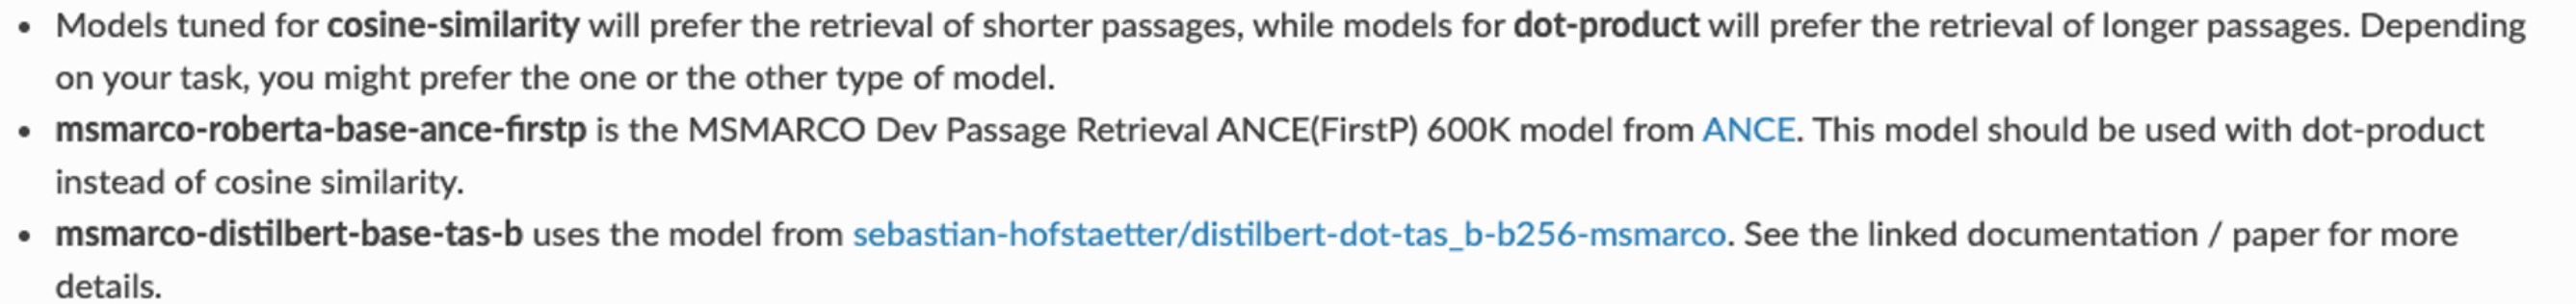

## Check if the abstract is climate-related

In [ ]:
climatebert_tokenizer = AutoTokenizer.from_pretrained("climatebert/distilroberta-base-climate-f")
climate_attention_model = RobertaForSequenceClassification.from_pretrained('kruthof/climateattention-ctw',
                                                                           num_labels=2)

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
def is_about_climate(texts):
    if torch.cuda.is_available():
      device = 0
      batch_size = 128
    else:
      device = -1
      batch_size = 1
    pipe = pipeline("text-classification", model=climate_attention_model,
                    tokenizer=climatebert_tokenizer, device=device,
                    truncation=True, padding=True)
    labels = []
    probs = []
    for out in pipe(texts, batch_size=batch_size):
        labels.append(out['label'])
        probs.append(out['score'])
    torch.cuda.empty_cache()
    return labels, probs

In [ ]:
def filter_climate_related(docs):
    abstracts = list(map(lambda doc: doc.content, docs))
    labels, _ = is_about_climate(abstracts)
    return [doc for label, doc in zip(labels, docs) if label == 'Yes']

## Class that deals with initiating and writing to faiss store

In [ ]:
class FAISSIndexer():
    def __init__(self, path_to_index_dir,
                 model_name, embedding_dim,
                 similarity_measure,
                 path_to_postgres=None) -> None:
        self.path_to_index_dir = path_to_index_dir
        # our db is postgres, only need to set path to faiss index
        if path_to_postgres:
            self.path_to_db = path_to_postgres
            self._set_path_to_index()
        # our db is SQLLite
        else:
            self._set_path_to_index_and_db()
        self.embedding_dim = embedding_dim
        self.model_name = model_name
        self.similarity_measure = similarity_measure
        self.document_store = self._init_document_store()
        self.retriever = self._init_retriever()

    def _set_path_to_index(self):
        if not os.path.exists(self.path_to_index_dir):
            os.makedirs(self.path_to_index_dir)
        self.path_to_index = os.path.join(self.path_to_index_dir, "faiss_index")

    def _set_path_to_index_and_db(self):
        self._set_path_to_index()
        self.path_to_db = f"sqlite:///{os.path.join(self.path_to_index_dir, 'faiss_document_store.db')}"

    def _init_document_store(self):
        if os.path.exists(self.path_to_index):
            return FAISSDocumentStore.load(index_path=self.path_to_index)
        else:
            return FAISSDocumentStore(
                sql_url=self.path_to_db,
                return_embedding=True,
                similarity=self.similarity_measure,
                embedding_dim=self.embedding_dim,
                duplicate_documents='skip'
            )

    def _init_retriever(self, progress_bar=True):
        return EmbeddingRetriever(
            document_store=self.document_store,
            embedding_model=self.model_name,
            model_format='sentence_transformers',
            # include article title into the embedding
            embed_meta_fields=["title"],
            progress_bar=progress_bar
        )

    def write_documents(self, docs):
        self.document_store.write_documents(docs)

        print('Updating embeddings ...')

        self.document_store.update_embeddings(
            retriever=self.retriever,
            update_existing_embeddings=False
        )

        print(f'current embedding count is {self.document_store.get_embedding_count()}')
        self.document_store.save(index_path=self.path_to_index)

    def retrieve_matches_for_a_phrase(self, phrase, top_k=10):
        return self.retriever.retrieve(phrase, top_k=top_k)

    def retrieve_matches_for_phrases(self, phrases, top_k=10):
        return self.retriever.retrieve_batch(phrases, top_k=top_k)


## Functions for indexing

In [ ]:
def index_docs_from_csv(filename, docs_extractor,
                        indexer, chunk_size, start_from_row,
                        check_climate_related=True):
    for docs in docs_extractor(filename, chunk_size, start_from_row):
        if check_climate_related:
            docs = filter_climate_related(docs)
        indexer.write_documents(docs)

In [ ]:
def convert_openalex_abstracts_to_haystack_documents(row):
    meta_information = {
        'title': row['title'],
        'year': row['year'],
        'doi': row['doi'],
        'openalex_id': row['openalex_id'],
        'citation_count': row['citationCount'],
        'influential_citation_count': row['influentialCitationCount']
    }
    return Document(content=row['abstract'],
                    meta=meta_information)

In [ ]:
def read_csv_yield_haystack_documents(filename, chunk_size, start_from_row):
    chunk_number = 1
    for df in pd.read_csv(filename, chunksize=chunk_size, skiprows=range(1, start_from_row)):
        print(f'starting to index chunk number {chunk_number}')
        df.fillna("", inplace=True)
        row_dict = df.to_dict('records')
        chunk_number += 1
        yield [convert_openalex_abstracts_to_haystack_documents(row)
               for row in row_dict]

## Launch the indexing process 

In [ ]:
# model to build semantic encodings
MODEL_NAME = 'sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco'
# embedding size used by distilbert-dot-tas_b-b256-msmarco
EMBEDDING_DIM = 768

chunk_size = 4096
start_from_row = 0

SIMILARITY = 'dot_product'

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)


In [ ]:
# start = timer()

# STORE_PATH = '/content/'
# csv_path = '/content/mod_abstracts_title_keyword_search.csv'

# faiss_indexer = FAISSIndexer(STORE_PATH, 
#                              MODEL_NAME, 
#                              EMBEDDING_DIM,
#                              SIMILARITY)
# index_docs_from_csv(csv_path,
#                     read_csv_yield_haystack_documents,
#                     faiss_indexer,
#                     chunk_size,
#                     start_from_row
#                     )

# end = timer()
# print(end - start)

starting to index chunk number 1


Writing Documents:   0%|          | 0/4011 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/4011 [00:00<?, ? docs/s]

Batches:   0%|          | 0/126 [00:00<?, ?it/s]

current embedding count is 4011
starting to index chunk number 2


Writing Documents:   0%|          | 0/2484 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/6495 [00:00<?, ? docs/s]

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

current embedding count is 6495
227.420068626


In [ ]:
chunk_size = 4096
start_from_row = 99 * chunk_size

start = timer()

csv_path = '/content/mod_abstracts_abstract_keyword_search.csv'
STORE_PATH = '/content/'
faiss_indexer = FAISSIndexer(STORE_PATH, 
                             MODEL_NAME, 
                             EMBEDDING_DIM,
                             SIMILARITY)

index_docs_from_csv(csv_path,
                    read_csv_yield_haystack_documents,
                    faiss_indexer,
                    chunk_size,
                    start_from_row
                    )

end = timer()
print(end - start)

starting to index chunk number 1


Writing Documents:   0%|          | 0/3893 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/10388 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 10388
starting to index chunk number 2


Writing Documents:   0%|          | 0/3872 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/14260 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 14260
starting to index chunk number 3


Writing Documents:   0%|          | 0/3875 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/18135 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 18135
starting to index chunk number 4


Writing Documents:   0%|          | 0/3892 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/22027 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 22027
starting to index chunk number 5


Writing Documents:   0%|          | 0/3905 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/25932 [00:00<?, ? docs/s]

Batches:   0%|          | 0/123 [00:00<?, ?it/s]

current embedding count is 25932
starting to index chunk number 6


Writing Documents:   0%|          | 0/3881 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/29813 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 29813
starting to index chunk number 7


Writing Documents:   0%|          | 0/3882 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/33695 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 33695
starting to index chunk number 8


Writing Documents:   0%|          | 0/3850 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/37545 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 37545
starting to index chunk number 9


Writing Documents:   0%|          | 0/3878 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/41423 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 41423
starting to index chunk number 10


Writing Documents:   0%|          | 0/3853 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/45276 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 45276
starting to index chunk number 11


Writing Documents:   0%|          | 0/3883 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/49159 [00:00<?, ? docs/s]

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

current embedding count is 49159
starting to index chunk number 12


Writing Documents:   0%|          | 0/3856 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/53015 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 53015
starting to index chunk number 13


Writing Documents:   0%|          | 0/3836 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/56851 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 56851
starting to index chunk number 14


Writing Documents:   0%|          | 0/3831 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/60682 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 60682
starting to index chunk number 15


Writing Documents:   0%|          | 0/3853 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/64535 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 64535
starting to index chunk number 16


Writing Documents:   0%|          | 0/3858 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/68393 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 68393
starting to index chunk number 17


Writing Documents:   0%|          | 0/3828 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/72221 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 72221
starting to index chunk number 18


Writing Documents:   0%|          | 0/3838 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/76059 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 76059
starting to index chunk number 19


Writing Documents:   0%|          | 0/3854 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/79913 [00:00<?, ? docs/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

current embedding count is 79913
starting to index chunk number 20


Writing Documents:   0%|          | 0/3818 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/83731 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 83731
starting to index chunk number 21


Writing Documents:   0%|          | 0/3810 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/87541 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 87541
starting to index chunk number 22


Writing Documents:   0%|          | 0/3817 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/91358 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 91358
starting to index chunk number 23


Writing Documents:   0%|          | 0/3816 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/95174 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 95174
starting to index chunk number 24


Writing Documents:   0%|          | 0/3820 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/98994 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 98994
starting to index chunk number 25


Writing Documents:   0%|          | 0/3821 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/102815 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 102815
starting to index chunk number 26


Writing Documents:   0%|          | 0/3813 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/106628 [00:00<?, ? docs/s]

Batches:   0%|          | 0/120 [00:00<?, ?it/s]

current embedding count is 106628
starting to index chunk number 27


Writing Documents:   0%|          | 0/3804 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/110432 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 110432
starting to index chunk number 28


Writing Documents:   0%|          | 0/3806 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/114238 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 114238
starting to index chunk number 29


Writing Documents:   0%|          | 0/3757 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/117995 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 117995
starting to index chunk number 30


Writing Documents:   0%|          | 0/3807 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/121802 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 121802
starting to index chunk number 31


Writing Documents:   0%|          | 0/3776 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/125578 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 125578
starting to index chunk number 32


Writing Documents:   0%|          | 0/3772 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/129350 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 129350
starting to index chunk number 33


Writing Documents:   0%|          | 0/3786 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/133136 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 133136
starting to index chunk number 34


Writing Documents:   0%|          | 0/3781 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/136917 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 136917
starting to index chunk number 35


Writing Documents:   0%|          | 0/3781 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/140698 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 140698
starting to index chunk number 36


Writing Documents:   0%|          | 0/3782 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/144480 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 144480
starting to index chunk number 37


Writing Documents:   0%|          | 0/3756 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/148236 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 148236
starting to index chunk number 38


Writing Documents:   0%|          | 0/3769 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/152005 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 152005
starting to index chunk number 39


Writing Documents:   0%|          | 0/3781 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/155786 [00:00<?, ? docs/s]

Batches:   0%|          | 0/119 [00:00<?, ?it/s]

current embedding count is 155786
starting to index chunk number 40


Writing Documents:   0%|          | 0/3746 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/159532 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 159532
starting to index chunk number 41


Writing Documents:   0%|          | 0/3753 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/163285 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 163285
starting to index chunk number 42


Writing Documents:   0%|          | 0/3739 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/167024 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 167024
starting to index chunk number 43


Writing Documents:   0%|          | 0/3766 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/170790 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 170790
starting to index chunk number 44


Writing Documents:   0%|          | 0/3734 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/174524 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 174524
starting to index chunk number 45


Writing Documents:   0%|          | 0/3748 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/178272 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 178272
starting to index chunk number 46


Writing Documents:   0%|          | 0/3754 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/182026 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 182026
starting to index chunk number 47


Writing Documents:   0%|          | 0/3724 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/185750 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 185750
starting to index chunk number 48


Writing Documents:   0%|          | 0/3746 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/189496 [00:00<?, ? docs/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

current embedding count is 189496
starting to index chunk number 49


Writing Documents:   0%|          | 0/3727 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/193223 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 193223
starting to index chunk number 50


Writing Documents:   0%|          | 0/3727 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/196950 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 196950
starting to index chunk number 51


Writing Documents:   0%|          | 0/3703 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/200653 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 200653
starting to index chunk number 52


Writing Documents:   0%|          | 0/3731 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/204384 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 204384
starting to index chunk number 53


Writing Documents:   0%|          | 0/3720 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/208104 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 208104
starting to index chunk number 54


Writing Documents:   0%|          | 0/3730 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/211834 [00:00<?, ? docs/s]

Batches:   0%|          | 0/117 [00:00<?, ?it/s]

current embedding count is 211834
starting to index chunk number 55


Writing Documents:   0%|          | 0/3702 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/215536 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 215536
starting to index chunk number 56


Writing Documents:   0%|          | 0/3711 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/219247 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 219247
starting to index chunk number 57


Writing Documents:   0%|          | 0/3693 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/222940 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 222940
starting to index chunk number 58


Writing Documents:   0%|          | 0/3699 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/226639 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 226639
starting to index chunk number 59


Writing Documents:   0%|          | 0/3693 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/230332 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 230332
starting to index chunk number 60


Writing Documents:   0%|          | 0/3666 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/233998 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 233998
starting to index chunk number 61


Writing Documents:   0%|          | 0/3698 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/237696 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 237696
starting to index chunk number 62


Writing Documents:   0%|          | 0/3695 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/241391 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 241391
starting to index chunk number 63


Writing Documents:   0%|          | 0/3708 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/245099 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 245099
starting to index chunk number 64


Writing Documents:   0%|          | 0/3695 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/248794 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 248794
starting to index chunk number 65


Writing Documents:   0%|          | 0/3704 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/252498 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 252498
starting to index chunk number 66


Writing Documents:   0%|          | 0/3689 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/256187 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 256187
starting to index chunk number 67


Writing Documents:   0%|          | 0/3700 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/259887 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 259887
starting to index chunk number 68


Writing Documents:   0%|          | 0/3669 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/263556 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 263556
starting to index chunk number 69


Writing Documents:   0%|          | 0/3697 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/267253 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 267253
starting to index chunk number 70


Writing Documents:   0%|          | 0/3658 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/270911 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 270911
starting to index chunk number 71


Writing Documents:   0%|          | 0/3708 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/274619 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 274619
starting to index chunk number 72


Writing Documents:   0%|          | 0/3685 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/278304 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 278304
starting to index chunk number 73


Writing Documents:   0%|          | 0/3665 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/281969 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 281969
starting to index chunk number 74


Writing Documents:   0%|          | 0/3660 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/285629 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 285629
starting to index chunk number 75


Writing Documents:   0%|          | 0/3666 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/289295 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 289295
starting to index chunk number 76


Writing Documents:   0%|          | 0/3633 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/292928 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 292928
starting to index chunk number 77


Writing Documents:   0%|          | 0/3648 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/296576 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 296576
starting to index chunk number 78


Writing Documents:   0%|          | 0/3685 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/300261 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 300261
starting to index chunk number 79


Writing Documents:   0%|          | 0/3687 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/303948 [00:00<?, ? docs/s]

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

current embedding count is 303948
starting to index chunk number 80


Writing Documents:   0%|          | 0/3640 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/307588 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 307588
starting to index chunk number 81


Writing Documents:   0%|          | 0/3629 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/311217 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 311217
starting to index chunk number 82


Writing Documents:   0%|          | 0/3640 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/314857 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 314857
starting to index chunk number 83


Writing Documents:   0%|          | 0/3621 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/318478 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 318478
starting to index chunk number 84


Writing Documents:   0%|          | 0/3660 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/322138 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 322138
starting to index chunk number 85


Writing Documents:   0%|          | 0/3655 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/325793 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 325793
starting to index chunk number 86


Writing Documents:   0%|          | 0/3484 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/329277 [00:00<?, ? docs/s]

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

current embedding count is 329277
starting to index chunk number 87


Writing Documents:   0%|          | 0/3647 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/332924 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 332924
starting to index chunk number 88


Writing Documents:   0%|          | 0/3628 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/336552 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 336552
starting to index chunk number 89


Writing Documents:   0%|          | 0/3670 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/340222 [00:00<?, ? docs/s]

Batches:   0%|          | 0/115 [00:00<?, ?it/s]

current embedding count is 340222
starting to index chunk number 90


Writing Documents:   0%|          | 0/3636 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/343858 [00:00<?, ? docs/s]

Batches:   0%|          | 0/114 [00:00<?, ?it/s]

current embedding count is 343858
starting to index chunk number 91


Writing Documents:   0%|          | 0/3573 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/347431 [00:00<?, ? docs/s]

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

current embedding count is 347431
starting to index chunk number 92


Writing Documents:   0%|          | 0/3570 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/351001 [00:00<?, ? docs/s]

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

current embedding count is 351001
starting to index chunk number 93


Writing Documents:   0%|          | 0/3590 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/354591 [00:00<?, ? docs/s]

Batches:   0%|          | 0/113 [00:00<?, ?it/s]

current embedding count is 354591
starting to index chunk number 94


Writing Documents:   0%|          | 0/3560 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/358151 [00:00<?, ? docs/s]

Batches:   0%|          | 0/112 [00:00<?, ?it/s]

current embedding count is 358151
starting to index chunk number 95


Writing Documents:   0%|          | 0/3542 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/361693 [00:00<?, ? docs/s]

Batches:   0%|          | 0/111 [00:00<?, ?it/s]

current embedding count is 361693
starting to index chunk number 96


Writing Documents:   0%|          | 0/3497 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/365190 [00:00<?, ? docs/s]

Batches:   0%|          | 0/110 [00:00<?, ?it/s]

current embedding count is 365190
starting to index chunk number 97


Writing Documents:   0%|          | 0/3480 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/368670 [00:00<?, ? docs/s]

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

current embedding count is 368670
starting to index chunk number 98


Writing Documents:   0%|          | 0/3329 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/371999 [00:00<?, ? docs/s]

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

current embedding count is 371999
starting to index chunk number 99


Writing Documents:   0%|          | 0/3220 [00:00<?, ?it/s]

Updating embeddings ...


Updating Embedding:   0%|          | 0/375219 [00:00<?, ? docs/s]

Batches:   0%|          | 0/101 [00:00<?, ?it/s]

current embedding count is 375219


ParserError: ignored

# Find abstracts relevant to the query

Even with such a small amount of abstracts the result looks fairly reasonable

In [ ]:
def get_abstracts_matching_claims(claims, store_path, top_k=10, debug=False):
    start = timer()
    faiss_indexer = FAISSIndexer(store_path, MODEL_NAME, EMBEDDING_DIM,
                             SIMILARITY)
    all_matches = faiss_indexer.retrieve_matches_for_phrases(claims,
                                                             top_k=top_k)
    if debug:
        for claim_n, matches in enumerate(all_matches):
            print(f"Claim:\n{claims[claim_n]}\n")
            for i, match in enumerate(matches):
                print(f'Evidence {i}:\n',
                      f'Similarity: {match.score:.3f}\n'
                      f'Abstract: {match.content}\n',
                      f'Article Title: {match.meta.get("title", "")}\n',
                      f'DOI: {match.meta.get("doi", "")}\n',
                      f'year: {match.meta.get("year", "")}\n',
                      f'citation_count: {match.meta.get("citation_count", "")}\n',
                      f'influential_citation_count: {match.meta.get("influential_citation_count", "")}\n', )
    end = timer()
    print(f"Took {(end - start):.0f} seconds")
    return all_matches

In [ ]:
get_abstracts_matching_claims(['CO2 is not the cause of our current warming trend.',
                               'Natural variation explains a substantial part of global warming observed since 1850'], 
                              store_path=STORE_PATH, debug=True);

/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Claim:
CO2 is not the cause of our current warming trend.

Evidence 0:
 Similarity: 0.716
Abstract: ‘Global warming’ is in the news almost daily these days, but rarely do we hear about its ‘evil twin’ or ‘the other carbon dioxide (CO 2 ) problem’, viz. ocean acidification. Global warming, caused mainly by anthropogenic CO 2 emissions, is apparently accompanied by ocean acidification, which is another major growing global problem with continued increase in atmospheric CO 2 levels. While there is large uncertainty in the detection and attribution of climate warming because of the large natural variability in surface temperatures, ocean acidification is relatively a certain and straight forward consequence of rising atmospheric CO 2 .
 Article Title: Is Ocean Acidification from Rising Carbon Dioxide a Grave Threat?
 DOI: 10.18520/cs/v114/i01/7-8
 year: 2018
 citation_count: 1.0
 influential_citation_count: 0.0

Evidence 1:
 Similarity: 0.713
Abstract: A basin‐wide warming in the North Atl